Training a LSTM model with ULMFIT approach on original text and then on reversed text. This is sort of  student model which is being trained on the predictions of a nother similar model. These predictions serve as the pseudo labels.

Inpiration source [here](https://www.kaggle.com/gurharkhalsa/backwards-forwards-ulmfit-ensemble).

In [1]:
#!pip install --no-index --find-links="../input/commonlit-pkgs-offline-download" spacy==3.1.1
!pip install spacy==3.1.1

     |████████████████████████████████| 6.4 MB 10.3 MB/s 
     |████████████████████████████████| 621 kB 12.3 MB/s 
     |████████████████████████████████| 456 kB 13.0 MB/s 
     |████████████████████████████████| 42 kB 1.0 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.5
    Uninstalling thinc-7.4.5:
      Successfully uninstalled thinc-7.4.5
  Attempting uninstall: spacy
    Found existing installation: spacy 2.3.7
    Uninstalling spacy-2.3.7:
      Successfully uninstalled spacy-2.3.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependenc

In [2]:
#!pip install --no-index --find-links="../input/commonlit-pkgs-offline-download" fastai==2.4.1
!yes Y|conda install -c fastai fastai=2.4.1

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | 

In [3]:
import fastai
fastai.__version__

'2.4.1'

## Import libraries

In [4]:
from typing import *
from pandas.core.frame import DataFrame
from fastai.text.all import *

In [5]:
path = Path('../input')
op_path = Path('/kaggle/working')
cbt_aug_pseudo_label = path/'commonlit-pseudo-labeler/pseudo_labels.csv'

In [6]:
df_cbt_aug_pseudo_label = pd.read_csv(cbt_aug_pseudo_label)

In [7]:
df_cbt_aug_pseudo_label.head(1)

,excerpt,target
0,"When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.\nThe floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.\nAt each end of the room, on the wall, hung a beautiful bear-skin rug.\nThe...",-0.340259


In [8]:
df_cbt_aug_pseudo_label.tail(1)

,excerpt,target
17408,"After the cutting came the sewing .The woman patted and pinned and fixed and joined , and then , turning to the man , she said : ` Now it is ready for you to try on . 'And she made him take off his coat , and stand up in front of her , and once more she patted an pinned and fixed and joined , and was very careful in smoothing out every wrinkle .` It does not feel very warm , ' observed the man at last , when he had borne all this patiently for a long time .` That is because it is so fine , ' answered she ; ` you do not want it to be as thick as the rough clothes you wear every day . 'He DI...",-1.360232


## The backwards model
Trained on text in reverse order

## The dataloader

In [9]:
dls_lm_back = TextDataLoaders.from_df(df_cbt_aug_pseudo_label, text_col='excerpt',
                                      is_lm=True, valid_pct=0.1,
                                      bs=256, seq_len=72, backwards=True)

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [10]:
dls_lm_back.show_batch(min_n=3)

,text,text_
0,". streets the through me following from him prevent could i that difficulty with even was it xxmaj . house the about went i wherever me attended he and , him fed alone i . playmate and pet favorite my was — name 's cat the was this — pluto xxmaj \n . remembered be to , now just , happens it that than reason better no for all at matter the","streets the through me following from him prevent could i that difficulty with even was it xxmaj . house the about went i wherever me attended he and , him fed alone i . playmate and pet favorite my was — name 's cat the was this — pluto xxmaj \n . remembered be to , now just , happens it that than reason better no for all at matter the mention"
1,"them for left was nothing .so help any them offering of intention no showed and , extravagance own their to misfortunes their attributed even friends former their that and , alone left were they that found soon they .but one possessed longer no they now houses their in staying their on insist would , rich were they while numerous so been had who , friends their that hoped first at daughters the","for left was nothing .so help any them offering of intention no showed and , extravagance own their to misfortunes their attributed even friends former their that and , alone left were they that found soon they .but one possessed longer no they now houses their in staying their on insist would , rich were they while numerous so been had who , friends their that hoped first at daughters the ,"
2,"nets great the and , out brought be to boats the for fixed was day a and , sun the of sight the at leapt villagers the of hearts the , longer grew light the and , began spring the when .but barn neighbouring some in dance a to come to her persuade could which or , them above flashing lights xxmaj northern xxmaj the with ride sleigh a for out her","great the and , out brought be to boats the for fixed was day a and , sun the of sight the at leapt villagers the of hearts the , longer grew light the and , began spring the when .but barn neighbouring some in dance a to come to her persuade could which or , them above flashing lights xxmaj northern xxmaj the with ride sleigh a for out her tempt"
3,"will it marry do i if xxmaj ` : instead answering herself found she , njal xxmaj called be must husband her that father her tell to mouth her opened she as but ; attention no pay to determined she so , it like not did and , name a such of heard never had girl the ' . habogi xxmaj called not is who one no marry xxmaj ` : whisper","it marry do i if xxmaj ` : instead answering herself found she , njal xxmaj called be must husband her that father her tell to mouth her opened she as but ; attention no pay to determined she so , it like not did and , name a such of heard never had girl the ' . habogi xxmaj called not is who one no marry xxmaj ` : whisper voice"
4,"at fearing , come had he path the down headlong rushed and , mantle his up caught he bound one .with ferns the by hidden half standing woman haired - golden beautiful a on fell rays its and , cloud a behind from passed moon the instant same the .at round look to him caused suddenly -- what know not did he -- something when , headlong in dive to about just","fearing , come had he path the down headlong rushed and , mantle his up caught he bound one .with ferns the by hidden half standing woman haired - golden beautiful a on fell rays its and , cloud a behind from passed moon the instant same the .at round look to him caused suddenly -- what know not did he -- something when , headlong in dive to about just was"
5,"ride could who one no was there hill glass the to got they when and , company their in him have not would brothers two the but , riding the at look to them with go to wanted .cinderlad days former the on as just went everything day third the .on brothers the said '' ! creature black dirty you , among grubbing sit you that ashes the than brighter little a","could who one no was there hill glass th

## The backwards model

In [11]:
learn_back = language_model_learner(dls_lm_back,
                               AWD_LSTM,
                               drop_mult=2.0,
                               metrics=[accuracy, Perplexity()], 
                               path=path,
                              wd=0.5).to_fp16()

## Training the model

In [12]:
learn_back.path = op_path

In [13]:
learn_back.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.242791,4.777219,0.230183,118.773613,05:23


In [14]:
def show_me_lrs(learn):
    suggestions = namedtuple('Suggestions', ["min", "steep",
                                            "valley", "slide"])
    lr_min, lr_steep,lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep,valley, slide))
    suggested_lrs = suggestions(lr_min, lr_steep, lr_valley, lr_slide)
    
    print(f"Minimum/10:\t{lr_min:.2e}\
          \nSteepest point:\t{lr_steep:.2e}\
          \nLongest valley:\t{lr_valley:.2e}\
          \nSlide interval:\t{lr_slide:.2e}")
    
    return suggested_lrs

/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


Minimum/10:	3.63e-04          
Steepest point:	3.31e-06          
Longest valley:	1.10e-04          
Slide interval:	7.59e-03


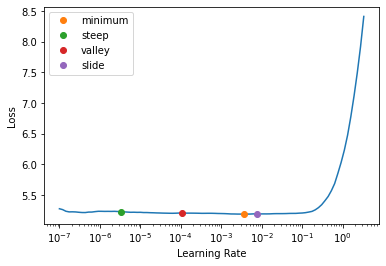

In [15]:
suggested_lrs = show_me_lrs(learn_back)

In [16]:
learn_back.unfreeze()
learn_back.fit_one_cycle(3, suggested_lrs.slide)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.922630,3.579395,0.330333,35.851837,05:55
1,3.345894,2.791880,0.452586,16.311663,05:55
2,3.021350,2.493838,0.513504,12.107652,05:54


good enough accuracy, let;s save it

In [17]:
learn_back.path = Path(".")
learn_back.save_encoder('./back_final_encoder')

## Backward Text regressor

In [18]:
data = DataBlock(
       blocks=(TextBlock.from_df('excerpt', 
                                 vocab=dls_lm_back.vocab, seq_len=72,
                                 backwards=True), RegressionBlock),
       get_x=ColReader('text'),get_y=ColReader('target'),
       splitter=TrainTestSplitter(test_size=0.2))

In [19]:
#data.summary(df_train)

In [20]:
dls_reg_back = data.dataloaders(df_cbt_aug_pseudo_label, bs=64)

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


## The regression model

In [21]:
learn_reg_back = text_classifier_learner(dls_reg_back, AWD_LSTM, drop_mult=2.0,
                                opt_func=Lamb,
                                metrics=rmse,
                                   wd=1.0).to_fp16()

In [22]:
learn_reg_back.path = Path(".")
learn_reg_back = learn_reg_back.load_encoder('./back_final_encoder')

## Training backwards regresion model

In [23]:
learn_reg_back.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,_rmse,time
0,1.322989,1.582463,1.257960,01:00


/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


Minimum/10:	2.75e-05          
Steepest point:	7.59e-07          
Longest valley:	6.92e-02          
Slide interval:	2.09e-01


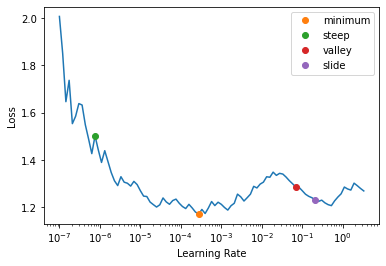

In [24]:
suggested_lrs = show_me_lrs(learn_reg_back)

In [25]:
learn_reg_back.freeze_to(-2)
learn_reg_back.fit_one_cycle(1, suggested_lrs.slide)

epoch,train_loss,valid_loss,_rmse,time
0,1.269623,1.327695,1.152256,01:13


/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


Minimum/10:	1.32e-07          
Steepest point:	9.12e-07          
Longest valley:	1.58e-04          
Slide interval:	2.09e-01


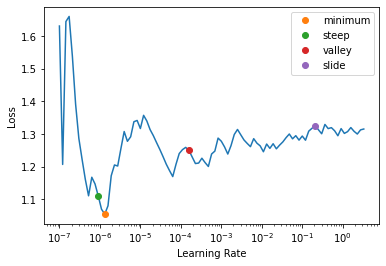

In [26]:
suggested_lrs = show_me_lrs(learn_reg_back)

In [27]:
learn_reg_back.freeze_to(-3)
learn_reg_back.fit_one_cycle(1, suggested_lrs.min)

epoch,train_loss,valid_loss,_rmse,time
0,1.347732,1.327695,1.152256,01:54


/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


Minimum/10:	4.37e-06          
Steepest point:	9.12e-07          
Longest valley:	3.02e-01          
Slide interval:	8.32e-02


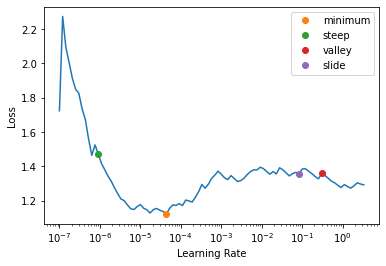

In [28]:
suggested_lrs = show_me_lrs(learn_reg_back)

In [29]:
learn_reg_back.unfreeze()
learn_reg_back.fit_one_cycle(10, suggested_lrs.slide)

epoch,train_loss,valid_loss,_rmse,time
0,1.232276,1.252768,1.119271,02:28
1,1.212633,1.174876,1.083917,02:28
2,1.308230,1.287886,1.134850,02:26
3,1.358390,1.337575,1.156536,02:27
4,1.226290,1.350776,1.162229,02:27
5,1.314486,1.355519,1.164268,02:28
6,1.303023,1.355501,1.164260,02:28
7,1.360729,1.356749,1.164796,02:28
8,1.418168,1.356745,1.164794,02:28
9,1.281214,1.356745,1.164794,02:28


In [30]:
learn_reg_back.export("./back_final_model")

## Create the forward model 

## The dataloader

In [31]:
dls_lm_forward = TextDataLoaders.from_df(df_cbt_aug_pseudo_label, text_col='excerpt',
                                      is_lm=True, valid_pct=0.1,
                                      bs=128, seq_len=72, backwards=False)

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [32]:
dls_lm_forward.show_batch(min_n=3)

,text,text_
0,xxbos xxmaj yuadoo is scared of the dark . xxmaj everyone feels fear sometimes . xxmaj but xxmaj yuadoo can ask for help . xxmaj chidubem is worried about his schoolwork . xxmaj he can tell his teacher . xxmaj he can ask for help . xxmaj lushan is playing around ! xxmaj it 's okay to be silly sometimes . xxmaj eruro is feeling sad . xxmaj it 's okay to,xxmaj yuadoo is scared of the dark . xxmaj everyone feels fear sometimes . xxmaj but xxmaj yuadoo can ask for help . xxmaj chidubem is worried about his schoolwork . xxmaj he can tell his teacher . xxmaj he can ask for help . xxmaj lushan is playing around ! xxmaj it 's okay to be silly sometimes . xxmaj eruro is feeling sad . xxmaj it 's okay to cry
1,"on the road , and so it happened that , one night , when he was sleeping in a city on the banks of the great river , a huge crocodile came silently up and made its way along a passage to the prince 's room .fortunately one of his guards woke up as it was trying to steal past them , and shut the crocodile up in a large hall ,","the road , and so it happened that , one night , when he was sleeping in a city on the banks of the great river , a huge crocodile came silently up and made its way along a passage to the prince 's room .fortunately one of his guards woke up as it was trying to steal past them , and shut the crocodile up in a large hall , where"
2,"and lamented , but all in vain , for go he must .then she asked him if she could not go with him .but no , that could not be . ` ` xxmaj can you tell me the way then , and i will seek you -- that i may surely be allowed to do ! '' ` ` xxmaj yes , you may do that , '' said he ;","lamented , but all in vain , for go he must .then she asked him if she could not go with him .but no , that could not be . ` ` xxmaj can you tell me the way then , and i will seek you -- that i may surely be allowed to do ! '' ` ` xxmaj yes , you may do that , '' said he ; `"
3,"to her master that someone had stolen both the bag and the bridge , and the xxmaj bad xxmaj one rushed in , mad with anger , and bade her go and seek for footsteps outside , that they might find out where the thief had gone . xxbos ` xxmaj that must be xxmaj mihrafruz , ' he thought , ` she is indeed lovely . ' just then one of","her master that someone had stolen both the bag and the bridge , and the xxmaj bad xxmaj one rushed in , mad with anger , and bade her go and seek for footsteps outside , that they might find out where the thief had gone . xxbos ` xxmaj that must be xxmaj mihrafruz , ' he thought , ` she is indeed lovely . ' just then one of the"
4,"field and see .they did go , and this time too the grass was standing , looking as fine and as thick as ever .the xxmaj king of the country in which xxmaj cinderlad 's father dwelt had a daughter whom he would give to no one who could not ride up to the top of the glass hill , for there was a high , high hill of glass , slippery","and see .they did go , and this time too the grass was standing , looking as fine and as thick as ever .the xxmaj king of the country in which xxmaj cinderlad 's father dwelt had a daughter whom he would give to no one who could not ride up to the top of the glass hill , for there was a high , high hill of glass , slippery as"
5,"for a long way -- it may have been a third part of the way up -- but when he had got so far he turned his horse round and rode down again .but the xxmaj princess thought that she had never yet seen so handsome a knight , and while he was riding up she was sitting thinking , ` ` xxmaj oh ! how i hope he may be able","a long way -- it may have been a third part of the way up -- but when he had got so far he turned his horse round and rode down again .but the xxmaj princess thought that she had never yet seen so handsome a knight , and while he was riding up she was sitting thinking , ` ` xxmaj oh ! how i hope he may be able to"
6,"way through the body , rivers to the rescue again ! xxmaj if rivers could speak , t

## The forward Language model

In [33]:
learn_forward = language_model_learner(dls_lm_forward,
                               AWD_LSTM,
                               drop_mult=2.0,
                               metrics=[accuracy, Perplexity()], 
                               path=path,
                              wd=0.5).to_fp16()

In [34]:
learn_forward.path = op_path

In [35]:
learn_forward.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.479300,3.891581,0.282506,48.988277,05:16


/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


Minimum/10:	1.58e-03          
Steepest point:	7.59e-07          
Longest valley:	1.00e-03          
Slide interval:	4.37e-03


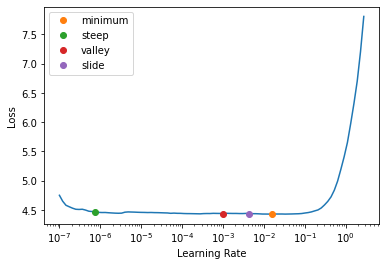

In [36]:
suggested_lrs = show_me_lrs(learn_forward)

In [37]:
learn_forward.unfreeze()
learn_forward.fit_one_cycle(3, suggested_lrs.slide)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.618451,3.171982,0.370171,23.854708,05:52
1,3.163433,2.697603,0.453273,14.844104,05:54
2,2.912815,2.432537,0.510846,11.387734,05:53


In [38]:
learn_forward.path = Path(".")
learn_forward.save_encoder('./forward_final_encoder')

## Forward Text Regressor

In [39]:
data = DataBlock(
       blocks=(TextBlock.from_df('excerpt', 
                                 vocab=dls_lm_forward.vocab, seq_len=72,
                                 backwards=False), RegressionBlock),
       get_x=ColReader('text'),get_y=ColReader('target'),
       splitter=TrainTestSplitter(test_size=0.2))

In [40]:
#data.summary(df_aug)

## The forward dataloader

In [41]:
dls_reg_forward = data.dataloaders(df_cbt_aug_pseudo_label, bs=64)

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [42]:
dls_reg_forward.show_batch()

,text,text_
0,"xxbos xxmaj the shops were all of a size , and all that dealt in the same sort of goods lived in one street ; as also the handicrafts - men , who kept their shops in the smaller streets .the multitude of shops , stocked with all sorts of merchandise , as the finest linens from several parts of xxmaj india , some painted in the most lively colors , and representing beasts , trees , and flowers ; silks and brocades from xxmaj persia , xxmaj china , and other places , porcelain both from xxmaj japan and xxmaj china , and tapestries , surprised him so much that he knew not how to believe his own eyes ; but when he came to the goldsmiths and jewelers he was in a kind of ecstacy to behold such prodigious quantities of wrought gold and silver , and was",-1.535057544708252
1,"xxbos xxmaj prince xxmaj houssain could not view this division without admiration .it was large , and divided into several streets , all vaulted and shaded from the sun , and yet very light too .the shops were all of a size , and all that dealt in the same sort of goods lived in one street ; as also the handicrafts - men , who kept their shops in the smaller streets .the multitude of shops , stocked with all sorts of merchandise , as the finest linens from several parts of xxmaj india , some painted in the most lively colors , and representing beasts , trees , and flowers ; silks and brocades from xxmaj persia , xxmaj china , and other places , porcelain both from xxmaj japan and xxmaj china , and tapestries , surprised him so much that he knew not how to believe",-1.5340027809143066
2,"xxbos xxmaj prince xxmaj houssain could not view this division without admiration .it was large , and divided into several streets , all vaulted and shaded from the sun , and yet very light too .the shops were all of a size , and all that dealt in the same sort of goods lived in one street ; as also the handicrafts - men , who kept their shops in the smaller streets .the multitude of shops , stocked with all sorts of merchandise , as the finest linens from several parts of xxmaj india , some painted in the most lively colors , and representing beasts , trees , and flowers ; silks and brocades from xxmaj persia , xxmaj china , and other places , porcelain both from xxmaj japan and xxmaj china , and tapestries , surprised him so much that he knew not how to believe",-1.5340027809143066
3,"xxbos xxmaj as soon as the caravan was ready to set out , the xxmaj prince joined them , and arrived happily without any accident or trouble , otherwise than the length of the journey and fatigue of traveling , at the place of rendezvous , where he found xxmaj prince xxmaj houssain , and both waited for xxmaj prince xxmaj ahmed .prince xxmaj ahmed , who took the road of xxmaj samarcand , the next day after his arrival there went , as his brothers had done , into the bezestein , where he had not walked long but heard a crier , who had an artificial apple in his hand , cry it at five and thirty purses ; upon which he stopped the crier , and said to him : ` ` xxmaj let me see that apple , and tell me what virtue and extraordinary properties",-1.515252709388733
4,"xxbos xxmaj as soon as the caravan was ready to set out , the xxmaj prince joined them , and arrived happily without any accident or trouble , otherwise than the length of the journey and fatigue of traveling , at the place of rendezvous , where he found xxmaj prince xxmaj houssain , and both waited for xxmaj prince xxmaj ahmed .prince xxmaj ahmed , who took the road of xxmaj samarcand , the next day after his arrival there went , as his brothers had done , into the bezestein , where he had not walked long but heard a crier , who had an artificial apple in his hand , cry it at five and thirty purses ; upon which he stopped the crier , and said to him : ` ` xxmaj let me see that apple , and tell me what virtue and extraordinary properties",-1.515252709388733
5,"xxbos xxmaj the crier , addressing himself to xxmaj prince xxmaj ali

## The regression model

In [43]:
learn_reg_forward = text_classifier_learner(dls_reg_forward, AWD_LSTM, drop_mult=2.0,
                                opt_func=Lamb,
                                metrics=rmse,
                                   wd=1.0).to_fp16()

In [44]:
learn_reg_forward.path = Path(".")
learn_reg_forward = learn_reg_forward.load_encoder('./forward_final_encoder')

## Training forward regression model

In [45]:
learn_reg_forward.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,_rmse,time
0,1.174593,1.582004,1.257777,01:01


/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


Minimum/10:	1.58e-07          
Steepest point:	6.31e-07          
Longest valley:	8.32e-02          
Slide interval:	4.79e-02


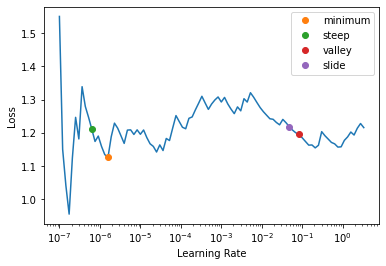

In [46]:
suggested_lrs = show_me_lrs(learn_reg_forward)

In [47]:
learn_reg_forward.freeze_to(-2)
learn_reg_forward.fit_one_cycle(1, suggested_lrs.slide)

epoch,train_loss,valid_loss,_rmse,time
0,1.152806,1.503283,1.226084,01:14


/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


Minimum/10:	5.75e-03          
Steepest point:	3.31e-06          
Longest valley:	4.37e-03          
Slide interval:	1.74e-01


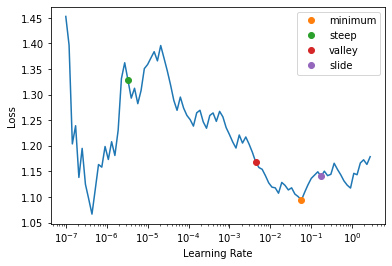

In [48]:
suggested_lrs = show_me_lrs(learn_reg_forward)

In [49]:
learn_reg_forward.freeze_to(-3)
learn_reg_forward.fit_one_cycle(1, suggested_lrs.slide)

epoch,train_loss,valid_loss,_rmse,time
0,0.991559,1.005136,1.002565,01:54


/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


Minimum/10:	2.75e-07          
Steepest point:	1.91e-06          
Longest valley:	1.20e-01          
Slide interval:	1.74e-01


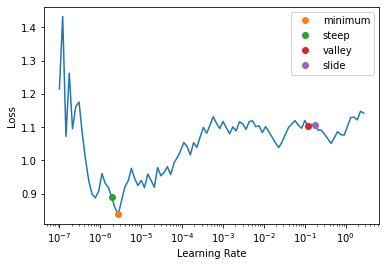

In [50]:
suggested_lrs = show_me_lrs(learn_reg_forward)

In [51]:
learn_reg_forward.unfreeze()
learn_reg_forward.fit_one_cycle(7, suggested_lrs.slide)

epoch,train_loss,valid_loss,_rmse,time
0,0.830327,0.879872,0.938015,02:28
1,1.261609,1.376222,1.173125,02:29
2,1.404444,1.380101,1.174777,02:30
3,1.311094,1.380101,1.174777,02:29
4,1.330402,1.380101,1.174777,02:29
5,1.439796,1.380101,1.174777,02:29
6,1.363186,1.380101,1.174777,02:30


In [52]:
learn_reg_forward.export("./forward_final_model")